Various imports and downloads

In [1]:
import sys
import csv

# increase the maxInt value
maxInt = sys.maxsize
while True:
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

import string
import statistics
import numpy as np
import re
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("stopwords")

!pip install Unidecode
import unidecode

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Functions used for text proecessing, file creation, and file updating. The majority of this utilizes the python regex library, csv writers and readers, and unidecode to convert the text to utf-8.

In [2]:
def preprocessAuthor(author, speakers, offices, discards, cap=True):
    # get rid of ending whitespace
    author = author.strip()

    # check if not a talk
    for d in discards:
        if d.lower() in author.lower():
            return ""

    # get just author name without added titles
    for o in offices:
        if o in author:
            regex = re.compile(".*"+o+"[.]?\s?")
            author = re.sub(regex, "", author)

    # check if speaker has enough talks
    if cap:
        viableSpeaker = False
        for s in speakers:
            if s == author:
                viableSpeaker = True
                break
        if not viableSpeaker:
            return ""

    # remove any ending punctuation if not an abbreviation like Jr.
    author_lst = author.split()
    if len(author_lst) > 1:
        last = author_lst[-1]
    elif len(author_lst) == 1:
        last = author_lst[0]
    else:
        return ""
    if len(last) > 3 and last[-1] in string.punctuation:
        author = author[:len(author)-1]
    # return the processed author name
    return author


def normalizeText(text):
    # get rid of punctuation
    nopunct = [char for char in text if char not in string.punctuation]
    nopunct = "".join(nopunct)

    # lemmatize
    lemmatiser = WordNetLemmatizer()
    a = ""
    words = nopunct.split()
    for i in range(len(words)):
        b = lemmatiser.lemmatize(words[i], pos="v")
        b = b.lower()
        a = a + b + " "

    # remove Stopwords
    words = [word for word in a.split() if word.lower()
             not in stopwords.words('english')]
    text = " ".join(words)

    return text


def preprocessText(text, author, decade, year, TEXT_LEN_CAP, normalize=True):

    words = text.split()
    if len(words) < TEXT_LEN_CAP:
        return ""

    test_text = text[:600]

    change_made = False

    # change the text to a normal utf-8 format
    text = unidecode.unidecode(text)

    # get rid of extra info before actual talk
    regex = re.compile(r"^COMMENTS. ")
    match_obj = re.search(regex, test_text[:50])
    if match_obj != None:
        change_made = True
        span = match_obj.span()
        text = text[span[1]:]

    regex = re.compile(r"^REMARKS. ")
    match_obj = re.search(regex, test_text[:50])
    if match_obj != None:
        change_made = True
        span = match_obj.span()
        text = text[span[1]:]

    dec_int = int(decade[:len(decade)-1])
    year = 0 if year == "" else int(year)
    if dec_int <= 1880 and (year == "" or year < 1880):
        regex = re.compile(rf"(R|r)eported by .*?  ")
        match_obj = re.search(regex, test_text)
        if match_obj != None:
            change_made = True
            span = match_obj.span()
            text = text[span[1]:]

    elif year >= 1971:
        regex = re.compile(r"(W|w)atch, listen, download.\s*")
        match_obj = re.search(regex, test_text)
        if match_obj != None:
            change_made = True
            span = match_obj.span()
            text = text[span[1]:]

    else:
        regex = re.compile(r".*as follows:  ")
        match_obj = re.search(regex, test_text)
        if match_obj != None:
            change_made = True
            span = match_obj.span()
            text = text[span[1]:]

        author = author.lower()
        counselors = "|((F|f)irst)|((S|s)econd) counselor"
        remarks = "|((O|o)pening)|((C|c)losing) remarks"
        options = "(O|o)f the |(A|a)ssistant" + counselors + \
            "|(P|p)resid" + remarks + "|(P|p)atriarch"
        regex = re.compile(
            rf"({author}(:|\.)?  (?!{options}))|({author}(:|\.)?  .*?  )")
        match_obj = re.search(regex, test_text.lower())
        if match_obj != None:
            change_made = True
            span = match_obj.span()
            text = text[span[1]:]

    # if after removing extra info, too small, reject document
    words = text.split()
    if len(words) < TEXT_LEN_CAP:
        return ""

    # if no change made, not in a good enough format to use
    if not change_made:
        return ""

    # change hyphens to spaces
    text = re.sub("-", " ", text)

    # create tokens that represent open quote and close quote
    text = re.sub(r'\s+"', " QUOTEOPEN ", text)
    text = re.sub(r'"\s+', " QUOTECLOSE ", text)

    # replace all scripture references with token "SCRIPREF"
    regex1 = re.compile(r"(\([^\)]*?:[^\)]*?\))|(\[[^\]]*?:[^\]]*?\])")
    text = re.sub(regex1, " SCRIPREF ", text)

    # get rid of all other paranthetical extras
    text = re.sub(r"\([^\)]*?\)", " ", text)

    # get rid of stopwords and punctuation, lemmatize the words
    if normalize:
        text = normalizeText(text)

    return text


def find_text_cap():
    text_lengths.sort()
    med = statistics.median(text_lengths)
    sd = statistics.stdev(text_lengths)
    print(med)
    print(sd)
    print(med-sd)

    from matplotlib import pyplot as plt

    print(len(text_lengths))
    plt.plot(text_lengths[:6000])

    Q1 = np.percentile(text_lengths, 25, interpolation='midpoint')
    Q3 = np.percentile(text_lengths, 75, interpolation='midpoint')
    IQR = Q3 - Q1
    print("Q1: ", Q1)
    print("Q3: ", Q3)
    print("IQR: ", IQR)
    k = 1.5
    lower_cap = Q1-k*IQR
    arr = np.array(text_lengths)
    small = arr[arr < 1578.5]
    small_q1 = np.percentile(small, 25, interpolation="midpoint")
    print(small_q1)


def initFile():
    # if it doesn't already exist create the fil; otherwise, clear the file
    file = open("/content/drive/MyDrive/NLP/newTexts.tsv", "w+")
    file.truncate(0)
    file.close()

    file = open("/content/drive/MyDrive/NLP/docIndex.txt", "w+")
    file.truncate(0)
    file.close()

    # add headers to the file
    with open("/content/drive/MyDrive/NLP/newTexts.tsv", "r+") as file:
        writer = csv.writer(file, delimiter="\t")
        response = ["author", "text"]
        writer.writerow(response)


def addDocToFile(author, text):
    # add a row to the newTexts.tsv file with the author and talk
    with open("/content/drive/MyDrive/NLP/newTexts.tsv", "a+") as file:
        writer = csv.writer(file, delimiter="\t")
        lst = []
        lst.append(author)
        lst.append(text)
        writer.writerow(lst)


def writeToFile(authors, texts):
    # open/create/clear file
    file = open("/content/drive/MyDrive/NLP/newTexts.tsv", "w+")
    file.truncate(0)
    file.close()

    # add all authors and texts to the file
    with open("/content/drive/MyDrive/NLP/newTexts.tsv", "r+") as file:
        writer = csv.writer(file, delimiter="\t")
        response = ["author", "text"]
        writer.writerow(response)
        for i in range(len(authors)):
            lst = []
            lst.append(authors[i])
            lst.append(texts[i])
            writer.writerow(lst)


Generating the new preprocessed corpus that will be used to train the sklearn multinomial naive bayes classifier. A portion of this code also extracts all of the speakers in the corpus and stores this list in a file. This file is later used to explore how author document count affects the overall model accuracy. This code only needs to be run once, since it saves the processed text in Google Drive.

This preprocessing took many hours, so it has been restructured to update the files progressively and in segments if needed.

In [3]:
# open the file
f = open("/content/drive/MyDrive/NLP/restructured-conference.tsv")
f_reader = csv.reader(f, delimiter="\t", quoting=csv.QUOTE_NONE)
# get headers
headers = next(f_reader)
# discard the open line
next(f_reader)

TEXT_LEN_CAP = 600

with open("/content/drive/MyDrive/NLP/speakers.txt") as file:
    speakers = [s.strip() for s in file.readlines()]
with open("/content/drive/MyDrive/NLP/titles.txt") as file:
    offices = [o.strip() for o in file.readlines()]
with open("/content/drive/MyDrive/NLP/discards.txt") as file:
    discards = [d.strip() for d in file.readlines()]

texts = []
authors = []
author_texts = {}
authors_set = set()
text_lengths = []

DOC_INDEX_START = 0


def init_speaker_count():
    file = open("/content/drive/MyDrive/NLP/speaker_counts.csv", "w+")
    file.truncate(0)
    file.close()

    '''
    file = open("/content/drive/MyDrive/NLP/speakers.txt", "w+")
    file.truncate(0)
    file.close()
    '''

    file = open("/content/drive/MyDrive/NLP/docIndex.txt", "w+")
    file.truncate(0)
    file.close()

    with open("/content/drive/MyDrive/NLP/speaker_counts.csv", "r+") as file:
        writer = csv.writer(file)
        response = ["speaker", "count"]
        writer.writerow(response)


def add_speaker(speaker: str):
    with open("/content/drive/MyDrive/NLP/speakers.txt", "a+") as file:
        file.write(speaker + "\n")


def get_speaker_count():
    speaker_counts = {}

    with open("/content/drive/MyDrive/NLP/speaker_counts.csv") as file:
        file_reader = csv.reader(file)
        next(file_reader)
        for row in file_reader:
            s = row[0]
            c = row[1]

            speaker_counts[s] = int(c)

    return speaker_counts


def create_author_doc_count_file():
    speaker_counts = {}
    with open("/content/drive/MyDrive/NLP/speakers.txt") as file:
        speakers = [speaker.strip() for speaker in file.readlines()]
        for s in speakers:
            if s not in speaker_counts:
                speaker_counts[s] = 1
            else:
                speaker_counts[s] += 1

    with open("/content/drive/MyDrive/NLP/speaker_counts.csv", "r+") as file:
        writer = csv.writer(file)
        for s in speaker_counts:
            response = [s, speaker_counts[s]]
            writer.writerow(response)


def create_speaker_file():
    f = open("/content/drive/MyDrive/NLP/restructured-conference.tsv")
    f_reader = csv.reader(f, delimiter="\t", quoting=csv.QUOTE_NONE)
    # get headers
    headers = next(f_reader)
    # discard the open line
    next(f_reader)

    with open("/content/drive/MyDrive/NLP/docIndex.txt") as file:
        DOC_INDEX_START = file.read()
        print(f"|{DOC_INDEX_START}|")
        if DOC_INDEX_START == "":
            DOC_INDEX_START = 0
        else:
            DOC_INDEX_START = int(DOC_INDEX_START)

    doc_index = 0

    for document in f_reader:
        decade = document[0]
        year = document[1]
        month = document[2]
        session_num = document[3]
        author = document[4]
        title = document[5]
        gender = document[6]
        role = document[7]
        subjects = document[8]
        text = document[9]

        doc_index += 1

        # startup where it left off
        if doc_index <= DOC_INDEX_START:
            continue

        author = preprocessAuthor(
            author, speakers, offices, discards, cap=False)
        if author == "":
            continue
        cpy = text
        text = preprocessText(text, author, decade, year,
                              TEXT_LEN_CAP, normalize=False)
        if text == "":
            continue

        add_speaker(author)
        #print("doc:", doc_index, "was added")
        with open("/content/drive/MyDrive/NLP/docIndex.txt", "w+") as file:
            file.write(str(doc_index))


def select_authors_and_docs():

    with open("/content/drive/MyDrive/NLP/docIndex.txt") as file:
        DOC_INDEX_START = file.read()
        print(f"|{DOC_INDEX_START}|")
        if DOC_INDEX_START == "":
            DOC_INDEX_START = 0
        else:
            DOC_INDEX_START = int(DOC_INDEX_START)

    print("Start doc: ", DOC_INDEX_START)

    doc_index = 0

    for document in f_reader:
        decade = document[0]
        year = document[1]
        month = document[2]
        session_num = document[3]
        author = document[4]
        title = document[5]
        gender = document[6]
        role = document[7]
        subjects = document[8]
        text = document[9]

        doc_index += 1

        # startup where it left off
        if doc_index <= DOC_INDEX_START:
            continue

        author = preprocessAuthor(author, speakers, offices, discards)
        if author == "":
            continue
        cpy = text
        text = preprocessText(text, author, decade, year, TEXT_LEN_CAP)
        if text == "":
            continue

        authors.append(author)
        texts.append(text)
        if author not in author_texts:
            author_texts[author] = [text]
            text_lengths.append(len(text.split()))
        else:
            author_texts[author].append(text)
            text_lengths.append(len(text.split()))

        addDocToFile(author, text)
        #print("doc:", doc_index, "was added")
        with open("/content/drive/MyDrive/NLP/docIndex.txt", "w+") as file:
            file.write(str(doc_index))


def get_speakers(cap=30):
    speaker_counts = get_speaker_count()
    speakers = []
    for s in speaker_counts:
        if speaker_counts[s] >= cap:
            speakers.append(s)
    return speakers

# init_speaker_count()
# create_author_doc_count_file()
#speaker_counts = get_speaker_count()

# initFile()
# select_authors_and_docs()
# timePreprocess()


Train the Multinomial Naive Bayes classifier on the preprocessed text

In [4]:
# imports and downloads
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# download these if skipping the previous cells in the notebook
import nltk
nltk.download("wordnet")
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Helper functions to get the necessary authors and texts lists to train the model. These functions are utilized to change up what authors, texts, and the preprocessing of the texts for each model test.

In [5]:
def getAuthorsAndTexts():
    f = open("/content/drive/MyDrive/NLP/newTexts.tsv")
    f_reader = csv.reader(f, delimiter="\t", quoting=csv.QUOTE_NONE)
    # get headers
    headers = next(f_reader)

    authors = []
    texts = []
    author_text_dict = {}
    author_doc_count = {}
    author_total_words = {}

    for document in f_reader:
        author = document[0]
        text = document[1]
        authors.append(author)
        texts.append(text)

        if author not in author_text_dict:
            author_text_dict[author] = [text]
            author_doc_count[author] = 1
            author_total_words[author] = len(text.split())
        else:
            author_text_dict[author].append(text)
            author_doc_count[author] += 1
            author_total_words[author] += len(text.split())

    return authors, texts, author_text_dict, author_doc_count, author_total_words

def text_process(text):
    return [word for word in text.split()]

def text_process_discards(text, discards=None):
    discards = ["quoteopen", "quoteclose", "scripref", "lord", "god", "say"] if discards == None else discards
    return [word for word in text.split() if word not in discards]

def discard(texts, discards):
    for i in range(len(texts)):
        text = texts[i]
        text = " ".join([word for word in text.split() if word not in discards])
        texts[i] = text
    return texts


The code used to train the multinomial naive bayes model and run various tests. The tests focus on how the document cap (getting rid of authors who have fewer documents attributed to them), the number of authors trained together (batch size), and how features like quotes and scripture references affect the overall model accuracy.

In [6]:
from sys import exit
from numpy.testing import assert_equal
from statistics import mean
from copy import deepcopy
from random import randint
from time import time

authors, texts, author_texts, author_doc_count, author_total_words = getAuthorsAndTexts()

def filter_by_authors(auth_lst):
    global authors
    global texts
    global author_texts
    global author_doc_count
    global author_total_words

    authors_new = []
    texts_new = []
    auths = set()
    for i, a in enumerate(authors):
        if a in auth_lst:
            authors_new.append(a)
            texts_new.append(texts[i])
            auths.add(a)

    return authors_new, texts_new, len(auths)


def filter_author_count(count=50):
    global authors
    global texts
    global author_texts
    global author_doc_count
    global author_total_words

    authors_new = []
    texts_new = []
    auths = set()
    for i, a in enumerate(authors):
        if author_doc_count[a] > count:
            authors_new.append(a)
            texts_new.append(texts[i])
            auths.add(a)

    return authors_new, texts_new, len(auths)


def mnb_model(authors, texts, discards=[], print_report=True):

    authors = deepcopy(authors)
    texts = deepcopy(texts)

    labelencoder = LabelEncoder()
    y = labelencoder.fit_transform(authors)
    authors_reverse = labelencoder.inverse_transform(y)
    labels = list(labelencoder.classes_)

    y_counts = {}
    for e in y:
        if e not in y_counts:
            y_counts[e] = 1
        else:
            y_counts[e] += 1

    author_word_count = {}
    for i, a in enumerate(authors):
        words = len(texts[i].split())
        if a not in author_word_count:
            author_word_count[a] = words
        else:
            author_word_count[a] += words

    texts = discard(texts, discards)
    X_train, X_test, y_train, y_test = train_test_split(
        texts, y, test_size=0.2)

    bow_transformer = CountVectorizer().fit(X_train)
    text_bow_train = bow_transformer.transform(X_train)
    text_bow_test = bow_transformer.transform(X_test)

    model = MultinomialNB()
    model = model.fit(text_bow_train, y_train)

    model.score(text_bow_train, y_train)
    model.score(text_bow_test, y_test)

    predictions = model.predict(text_bow_test)
    report = classification_report(
        y_test, predictions, zero_division=0, output_dict=True)
    report_str = classification_report(
        y_test, predictions, zero_division=0, output_dict=False)
    if print_report:
        min = np.inf
        max = 0
        mins = []
        wpds = []
        print("{:<25} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
            "", "precision", "recall", "f1-score", "documents", "words", "wpd"))
        for item in report:
            # print(item)
            if item == "accuracy":
                print()
                l = "accuracy"
                p = " "
                r = " "
                f = round(report[item], 2)
                d = " "
                w = " "
                wpd = " "
            elif item == "micro avg":
                l = "micro avg"
                p = round(report[item]["precision"], 2)
                r = round(report[item]["recall"], 2)
                f = round(report[item]["f1-score"], 2)
                d = " "
                w = " "
                wpd = " "
            elif item == "weighted avg":
                l = "weighted avg"
                p = round(report[item]["precision"], 2)
                r = round(report[item]["recall"], 2)
                f = round(report[item]["f1-score"], 2)
                d = " "
                w = " "
                wpd = " "
            elif item == "macro avg":
                l = "macro avg"
                p = round(report[item]["precision"], 2)
                r = round(report[item]["recall"], 2)
                f = round(report[item]["f1-score"], 2)
                d = " "
                w = " "
                wpd = " "
            else:
                l = labels[int(item)]
                p = round(report[item]["precision"], 2)
                r = round(report[item]["recall"], 2)
                f = round(report[item]["f1-score"], 2)
                d = y_counts[int(item)]
                w = author_word_count[l]
                wpd = w/d

                if f == 0.0 and d > max:
                    max = d
                if f > 0 and d < min:
                    min = d

                wpds.append(w/d)

            print("{:<25} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
                l, p, r, f, d, w, wpd))
        print("minimum documents to produce results was min: {} max: {}".format(min, max))
        print("average word per doc: {}".format(mean(wpds)))

        # print(report_str)

    results = {}
    results["model"] = model
    results["labels"] = labels
    results["y_counts"] = y_counts
    results["author_word_count"] = author_word_count

    return results, report


def run_cap_test(discards=[], label=""):
    doc_caps, accuracies, author_counts, remainings = [], [], [], []

    authors_set = set()
    prev_authors_set = set()

    for iteration in range(10):
        print("iteration {} / {}".format(iteration+1, 10), end=" : ")
        start = time()
        for i in range(25, 100, 5):
            auths_test, texts_test, auths = filter_author_count(i)
            authors_set = set(auths_test)
            m, r = mnb_model(auths_test, texts_test,
                             discards=discards, print_report=False)
            remaining = prev_authors_set - authors_set
            doc_caps.append(i)
            accuracies.append(r["accuracy"])
            author_counts.append(auths)
            remainings.append(remaining)
            prev_authors_set = deepcopy(authors_set)

            #print(i, " : ", r["accuracy"], " : ", auths, " : ", remaining)
        end = time()
        print("it took {} minutes".format((end-start)/60))

    file = open("/content/drive/MyDrive/NLP/doc_acc_relation" +
                str(label)+".csv", "w+")
    file.close()

    with open("/content/drive/MyDrive/NLP/doc_acc_relation"+str(label)+".csv", "r+") as file:
        writer = csv.writer(file)
        header = ["document min", "accuracy",
                  "number of valid authors", "discarded authors"]
        writer.writerow(header)
        for i in range(len(doc_caps)):
            cap = doc_caps[i]
            acc = accuracies[i]
            auth = author_counts[i]
            rem = remainings[i]

            response = [cap, acc, auth, rem]
            writer.writerow(response)


def author_amount_test(discards=[], label=""):
    lst = []
    with open("/content/drive/MyDrive/NLP/doc_acc_relation"+str(label)+".csv") as file:
        f_reader = csv.reader(file)
        next(f_reader)
        for line in f_reader:
            text = line[3]
            if text != "set()":
                lst = lst + text[2:len(text)-2].split("', '")
    # print(lst)
    lst = list(set(lst))
    #lst = lst[:len(lst)-2]
    # print(len(lst))

    rows = []
    for iteration in range(10):
        print("iteration {} / {}".format(iteration+1, 10), end=" : ")
        start = time()
        rows = []
        for size in range(4, len(lst), 4):
            batches = []
            total = 0
            author_bank = deepcopy(lst)
            counter = 0
            batch = []
            while len(author_bank) > 0:
                a = author_bank.pop(randint(0, len(author_bank)-1))
                batch.append(a)
                counter += 1
                if counter >= size:
                    counter = 0
                    batches.append(batch)
                    batch = []

            counts, accuracies, dpa = [], [], []

            accuracies = []
            reg_size = len(batches[0])
            for b in batches:
                if len(b) == reg_size:
                    authors_batch, texts_batch, authors_count = filter_by_authors(b)
                    m, r = mnb_model(authors_batch, texts_batch,
                                     discards=discards, print_report=False)

                    counts.append(authors_count)
                    accuracies.append(r["accuracy"])
                    dpa.append(len(texts_batch)/authors_count)

                    rows.append([authors_count, r["accuracy"],
                                len(texts_batch)/authors_count])
                    #print(authors_count, " : ", r["accuracy"], " : ", len(texts_batch)/authors_count, " : ", set(authors_batch))
        end = time()
        print("it took {} minutes".format((end-start)/60))
        with open("/content/drive/MyDrive/NLP/auth_count_acc_relation"+str(label)+".csv", "a+") as file:
            writer = csv.writer(file)
            for r in rows:
                writer.writerow(r)


def discards_test():
    discards = [["quoteopen", "quoteclose", "scripref"], [
        "quoteopen", "quoteclose"], ["scripref"], [], ["quoteclose"]]
    labels = ["normal", "ref", "quotes", "ref_quotes", "quote_open"]

    for i, d in enumerate(discards):
        print("DISCARD NUMBER {}".format(i))
        with open("/content/drive/MyDrive/NLP/auth_count_acc_relation"+str("_"+labels[i])+".csv", "w+") as file:
            file.truncate(0)
        with open("/content/drive/MyDrive/NLP/auth_count_acc_relation"+str("_"+labels[i])+".csv", "r+") as file:
            writer = csv.writer(file)
            header = ["author count", "accuracy", "avg doc_per_author"]
            writer.writerow(header)

        authors, texts, auths_count = filter_author_count(60)
        #run_cap_test(d, str("_"+labels[i]))
        author_amount_test(d, str("_"+labels[i]))


def write_report_to_file(results, report):

    y_counts = results["y_counts"]
    author_word_count = results["author_word_count"]
    labels = results["labels"]

    min = np.inf
    max = 0
    mins = []
    wpds = []

    file = open("/content/drive/MyDrive/NLP/model_results.csv", "w+")
    file.truncate(0)
    writer = csv.writer(file)
    header = ["author", "precision", "recall",
              "f1-score", "documents", "words", "wpd"]
    writer.writerow(header)

    print("{:<25} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
        "", "precision", "recall", "f1-score", "documents", "words", "wpd"))
    for item in report:
        # print(item)
        if item == "accuracy":
            print()
            l = "accuracy"
            p = " "
            r = " "
            f = round(report[item], 2)
            d = " "
            w = " "
            wpd = " "
        elif item == "micro avg":
            l = "micro avg"
            p = round(report[item]["precision"], 2)
            r = round(report[item]["recall"], 2)
            f = round(report[item]["f1-score"], 2)
            d = " "
            w = " "
            wpd = " "
        elif item == "weighted avg":
            l = "weighted avg"
            p = round(report[item]["precision"], 2)
            r = round(report[item]["recall"], 2)
            f = round(report[item]["f1-score"], 2)
            d = " "
            w = " "
            wpd = " "
        elif item == "macro avg":
            l = "macro avg"
            p = round(report[item]["precision"], 2)
            r = round(report[item]["recall"], 2)
            f = round(report[item]["f1-score"], 2)
            d = " "
            w = " "
            wpd = " "
        else:
            l = labels[int(item)]
            p = round(report[item]["precision"], 2)
            r = round(report[item]["recall"], 2)
            f = round(report[item]["f1-score"], 2)
            d = y_counts[int(item)]
            w = author_word_count[l]
            wpd = w/d

            if f == 0.0 and d > max:
                max = d
            if f > 0 and d < min:
                min = d

            wpds.append(w/d)

        print("{:<25} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}".format(
            l, p, r, f, d, w, wpd))
        writer.writerow([l, p, r, f, d, w, wpd])

    file.close()
    print("minimum documents to produce results was min: {} max: {}".format(min, max))
    print("average word per doc: {}".format(mean(wpds)))


def run_mnb_model():
    authors, texts, auths_count = filter_author_count(100)
    results, report = mnb_model(authors, texts, discards=[
                                "quoteclose"], print_report=False)
    write_report_to_file(results, report)


def table_for_paper():
    file = open("/content/drive/MyDrive/NLP/model_results.csv")
    f_reader = csv.reader(file)
    next(f_reader)
    for line in f_reader:
        string = "\\verb|{}| & \\verb|{}| & \\verb|{}| & \\verb|{}| & \\verb|{}| \\\\"\
            .format(line[0], line[1], line[2], line[3], line[4])
        print(string)


run_mnb_model()
# table_for_paper()
# discards_test()
# author_amount_test()
# run_cap_test()
#mnb_model(authors, texts)


                          precision  recall     f1-score   documents  words      wpd       
Boyd K. Packer            1.0        0.56       0.71       107        113221     1058.1401869158879
Brigham Young             0.87       0.95       0.9        242        638475     2638.3264462809916
David O. McKay            0.92       1.0        0.96       180        202131     1122.95   
Ezra Taft Benson          0.83       0.75       0.79       112        141063     1259.4910714285713
George Q. Cannon          0.64       0.88       0.74       140        315889     2256.35   
Gordon B. Hinckley        0.61       1.0        0.76       234        235563     1006.6794871794872
Heber J. Grant            0.8        0.84       0.82       112        182827     1632.3839285714287
James E. Faust            1.0        0.38       0.55       103        113788     1104.7378640776699
John Taylor               0.92       0.96       0.94       155        364000     2348.3870967741937
Joseph F. Smith         

Analsysis and plotting of each of the tests

In [7]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import operator
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

!pip install folium==0.2.1
!pip install pdflatex
!sudo apt-get install texlive-latex-recommended 
!sudo apt install texlive-latex-extra
!sudo apt install dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


correlation coefficient between documents-precision is: -0.35813566006372377
correlation coefficient between documents-recall is: 0.6661082203133981
correlation coefficient between documents-f1-score is: 0.48165975819693846


<Figure size 432x288 with 0 Axes>

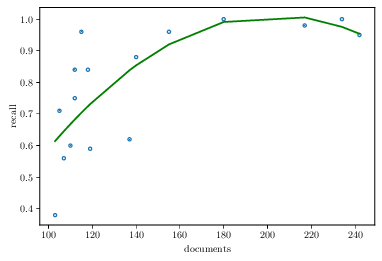

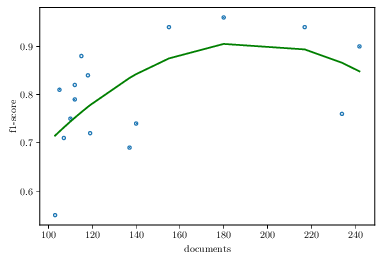

In [8]:

# 455.24408
def set_size(width_pt, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


def export_plot(plt, name, full_address=False):
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
    if full_address:
        filename = name + ".pgf"
    else:
        filename = "/content/drive/MyDrive/NLP/" + name + ".pgf"
    plt.savefig(filename, transparent=False, figsize=set_size(
        450/2), bbox_inches='tight', dpi=100)
    plt.show()


def export_test():

    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

    filename = "/content/drive/MyDrive/NLP/export_test.csv"
    df = pd.read_csv(filename)\
        .groupby("document min").mean()["accuracy"].to_frame()\
        .rename(columns={"accuracy": "quotes"})
    plt.figure(figsize=set_size(455/2))
    df.plot.line()

    plt.savefig("/content/drive/MyDrive/NLP/export_test_file.pgf",
                transparent=False, figsize=set_size(450/2), bbox_inches='tight', dpi=100)


def analysis():

    # test how number of authors in training set affect accuracy

    # filenames
    author_filenames = ["/content/drive/MyDrive/NLP/auth_count_acc_relation_normal.csv",
                        "/content/drive/MyDrive/NLP/auth_count_acc_relation_quote_open.csv",
                        "/content/drive/MyDrive/NLP/auth_count_acc_relation_quotes.csv",
                        "/content/drive/MyDrive/NLP/auth_count_acc_relation_ref.csv",
                        "/content/drive/MyDrive/NLP/auth_count_acc_relation_ref_quotes.csv"]
    types = ["normal", "quotesopen", "quotes", "scripref", "ref_quotes"]

    # get data frames for each file
    dfs = []
    for i, filename in enumerate(author_filenames):
        df = pd.read_csv(filename)\
            .groupby("author count").mean()["accuracy"].to_frame()\
            .rename(columns={"accuracy": types[i]})
        dfs.append(df)

    # condense dataframes into one dataframe
    df_authors = pd.concat(dfs, axis=1, join="inner")

    # show the head of the data frame and plot the whole dataframe
    print(df_authors.head())
    plt.figure()
    lines = df_authors.plot.line()
    export_plot(plt, "auth_count_acc_relation")
    #plt.savefig(str("/content/drive/MyDrive/NLP/auth_count_acc_relation.png"), transparent=False, bbox_inches='tight', figsize=(100,60), dpi=100)

    # split up the plot into five sections and plot those
    n = len(df_authors.index)
    s = n // 4
    split_df_authors = []
    for i in range(0, n, s):
        split_df_authors.append(df_authors.iloc[i:i+s, :])
    for i, df in enumerate(split_df_authors):
        plt.figure()
        df.plot.line()
        name_len = len(author_filenames[i])
        name = author_filenames[i][:name_len-4]+".png"
        export_plot(plt, name[:len(name)-4], full_address=True)
        #plt.savefig(name, transparent=False, bbox_inches='tight', figsize=(100,60), dpi=100)

    # test how discarding less frequent authors affects accuracy

    # filenames
    doc_filenames = ["/content/drive/MyDrive/NLP/doc_acc_relation_normal.csv",
                     "/content/drive/MyDrive/NLP/doc_acc_relation_quote_open.csv",
                     "/content/drive/MyDrive/NLP/doc_acc_relation_quotes.csv",
                     "/content/drive/MyDrive/NLP/doc_acc_relation_ref.csv",
                     "/content/drive/MyDrive/NLP/doc_acc_relation_ref_quotes.csv"]

    # get data frames for each file
    dfs = []
    for i, filename in enumerate(doc_filenames):
        df = pd.read_csv(filename)\
            .groupby("document min").mean()["accuracy"].to_frame()\
            .rename(columns={"accuracy": types[i]})
        dfs.append(df)

    # condense dataframes into one dataframe
    df_docs = pd.concat(dfs, axis=1, join="inner")

    # show the head of the data frame and plot the whole dataframe
    print(df_docs.head())
    plt.figure()
    lines = df_docs.plot.line()
    export_plot(plt, "doc_acc_relation")
    #plt.savefig(str("/content/drive/MyDrive/NLP/doc_acc_relation.png"), transparent=False, bbox_inches='tight', figsize=(100,60), dpi=100)

    # split up the plot into five sections and plot those
    n = len(df_docs.index)
    s = n // 4
    split_df_docs = []
    for i in range(0, n, s):
        split_df_docs.append(df_docs.iloc[i:i+s, :])

    for i, df in enumerate(split_df_docs):
        plt.figure()
        df.plot.line()
        name_len = len(doc_filenames[i])
        name = doc_filenames[i][:name_len-4]+".png"
        export_plot(plt, name[:len(name)-4], full_address=True)
        #plt.savefig(name, transparent=False, bbox_inches='tight', figsize=(100,60), dpi=100)


def plot_with_line(x, y):

    x_name = x.name
    y_name = y.name

    x = x.to_numpy()
    y = y.to_numpy()

    x = x[:, np.newaxis]
    y = y[:, np.newaxis]

    polynomial_features = PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    rmse = np.sqrt(mean_squared_error(y, y_poly_pred))
    r2 = r2_score(y, y_poly_pred)
    # print(rmse)
    # print(r2)

    plt.figure()
    plt.scatter(x, y, s=10)
    # sort the values of x before line plot
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x, y_poly_pred), key=sort_axis)
    x, y_poly_pred = zip(*sorted_zip)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot(x, y_poly_pred, color='g')
    export_plot(plt, str(x_name + "-" + y_name + " relation"))


def show_prfd_relations():
    df = pd.read_csv("/content/drive/MyDrive/NLP/model_results.csv")
    df = df[(df["author"] != "accuracy") & (df["author"] !=
                                            "macro avg") & (df["author"] != "weighted avg")]
    df["precision"] = pd.to_numeric(
        df["precision"], downcast="float", errors='coerce')
    df["documents"] = pd.to_numeric(
        df["documents"], downcast="integer", errors='coerce')
    df["recall"] = pd.to_numeric(
        df["recall"], downcast="float", errors='coerce')
    df["f1-score"] = pd.to_numeric(df["f1-score"],
                                   downcast="float", errors='coerce')
    df["recall"] = pd.to_numeric(
        df["recall"], downcast="float", errors='coerce')

    plot_with_line(df["documents"], df["precision"])
    #df.plot.scatter(x="documents", y="precision")
    print("correlation coefficient between {}-{} is: {}".format("documents",
          "precision", df["documents"].corr(df["precision"])))

    plot_with_line(df["documents"], df["recall"])
    #df.plot.scatter(x="documents", y="recall")
    print("correlation coefficient between {}-{} is: {}".format("documents",
          "recall", df["documents"].corr(df["recall"])))

    plot_with_line(df["documents"], df["f1-score"])
    #df.plot.scatter(x="documents", y="f1-score")
    print("correlation coefficient between {}-{} is: {}".format("documents",
          "f1-score", df["documents"].corr(df["f1-score"])))


# export_test()
# analysis()
show_prfd_relations()


Generate and save some word clous for each of the authors.

In [9]:
from copy import deepcopy
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def generateWordClouds():

    authors, texts, author_texts = getAuthorsAndTexts()

    condensed_author_texts = {}
    for author in author_texts:
        print(author)
        texts = author_texts[author]
        t = ""
        for text in texts:
            t = t + text + " "
        condensed_author_texts[author] = t

    favs = []
    with open("/content/drive/MyDrive/NLP/fav_speakers.txt") as file:
        content = file.readlines()
        content = [line.strip() for line in content]
        favs = deepcopy(content)

    for author in condensed_author_texts:
        text = condensed_author_texts[author]
        discards = ["quoteopen", "quoteclose",
                    "scripref", "lord", "god", "say"]
        text = [word for word in text.split() if word not in discards]
        text = " ".join(text)
        wordCloud = WordCloud().generate(text)
        plt.title(author)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(wordCloud, interpolation='bilinear')
        #plt.savefig(str("/content/drive/MyDrive/NLP/speakerWordClouds/"+author+"_trans.png"), transparent=True, bbox_inches='tight', figsize=(100,60), dpi=100)
        plt.savefig(str("/content/drive/MyDrive/NLP/speakerWordClouds/"+author+".png"),
                    transparent=False, bbox_inches='tight', figsize=(100, 60), dpi=100)
        if author in favs:
            #plt.savefig(str("/content/drive/MyDrive/NLP/favs/"+author+"_trans.png"), bbox_inches='tight', transparent=True, figsize=(100,60), dpi=100)
            plt.savefig(str("/content/drive/MyDrive/NLP/favs/"+author+".png"),
                        bbox_inches='tight', transparent=False, figsize=(100, 60), dpi=100)
        # plt.show()
